In [5]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset
from compare_variance_residual.variance_partitioning import variance_partitioning

In [2]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying noise")
    os.makedirs(path, exist_ok=True)
    return path

In [3]:
def save_scores(noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for noise_target in noise_levels:
        print(noise_target)
        csv_path = os.path.join(path, f"scores_{noise_target}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score
        print(scores.head())

        _, _, x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying noise levels

In [6]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [7]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
scalars = [1 / 3, 1 / 3, 1 / 3]

cv = 10
alphas = np.logspace(-5, 5, 10)

In [31]:
nstep = 11
noise_levels = np.logspace(-10.0, 0.0, nstep)
noise_levels = np.insert(noise_levels, 0, 0.0)

array([0.e+00, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04,
       1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [ ]:
save_scores(noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas)

1e-10
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0   0.65679   0.64508         0.99707          0.30479             0.35200   
1   0.61811   0.66174         0.99626          0.28358             0.33453   
2   0.64817   0.72769         0.99823          0.37763             0.27054   
3   0.65910   0.67411         0.99741          0.33580             0.32330   
4   0.60624   0.55795         0.99620          0.16800             0.43824   

   vp_x2_unique_score  
0             0.34028  
1             0.37815  
2             0.35006  
3             0.33831  
4             0.38996  
residual method done
1e-09
data generated


# Plot scores

In [10]:
vp = pd.DataFrame()
rm = pd.DataFrame()

for i, noise_level in enumerate(noise_levels):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{noise_level}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_x1_se = (vp_x1_unique_predicted - scalars[1]).std()
    vp_scores = pd.DataFrame({
        'noise_target': noise_level,
        'vp_joint_score': scores['vp_joint_score'].mean(),
        'vp_x1_unique_score': vp_x1_unique_predicted.mean(),
        'vp_x1_se': vp_x1_se,
        'vp_x1_lower_se': vp_x1_unique_predicted.mean() - vp_x1_se,
        'vp_x1_upper_se': vp_x1_unique_predicted.mean() + vp_x1_se
    }, index=[i])

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_x1_se = (rm_x1_unique_score - scalars[1]).std()
    rm_scores = pd.DataFrame({
        'noise_target': noise_level,
        'rm_x1_unique_score': rm_x1_unique_score.mean(),
        'rm_x1_se': rm_x1_se,
        'rm_x1_lower_se': rm_x1_unique_score.mean() - rm_x1_se,
        'rm_x1_upper_se': rm_x1_unique_score.mean() + rm_x1_se
    }, index=[i])

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
vp.head()
rm.head()

,noise_target,rm_x1_unique_score,rm_x1_se,rm_x1_lower_se,rm_x1_upper_se
0,0.00,0.307141,0.083135,0.224006,0.390276
1,0.01,0.303787,0.083121,0.220666,0.386908
2,0.10,0.273974,0.082804,0.191169,0.356778
3,0.50,0.141217,0.066735,0.074482,0.207952


Text(0, 0.5, 'Predicted Unique Variance (avg. $R^2$)')

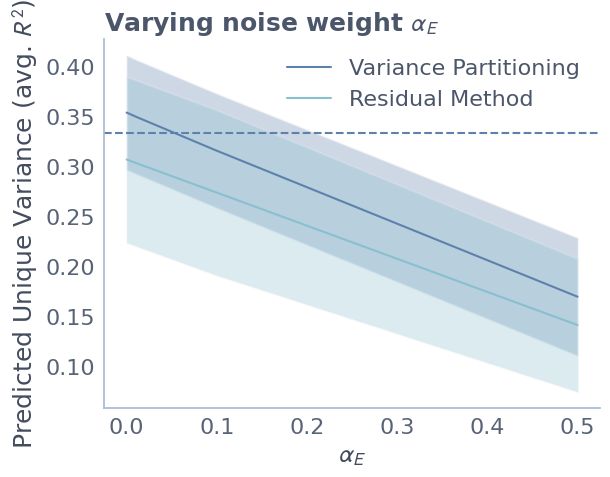

In [11]:
hue_order = ['Residual Method', 'Variance Partitioning', ]
sns.lineplot(data=vp, x='noise_target', y='vp_x1_unique_score', label='Variance Partitioning', palette='C2')
plt.fill_between(vp['noise_target'], vp['vp_x1_lower_se'], vp['vp_x1_upper_se'], alpha=0.3)
sns.lineplot(data=rm, x='noise_target', y='rm_x1_unique_score', label='Residual Method', hue_order=hue_order)
plt.fill_between(rm['noise_target'], rm['rm_x1_lower_se'], rm['rm_x1_upper_se'], alpha=0.3)
plt.axhline(scalars[1], linestyle='--', label='true unique variance')
plt.title(r"Varying noise weight $\alpha_E$")
plt.xlabel(r"$\alpha_E$")
plt.ylabel(r"Predicted Unique Variance (avg. $R^2$)")